Try and keep it to cpu rather than gpu
1. have a couple options for embedding styles (pass function into another function)
2. use pillow histogram initially

In [113]:
import pynndescent # https://pynndescent.readthedocs.io/en/latest/how_to_use_pynndescent.html#Nearest-neighbors-of-the-training-set
from PIL import Image # Pillow
import os # for getting filenames

from concurrent.futures import ThreadPoolExecutor # for parallel processing
from tqdm import tqdm # for progress bars

import numpy as np

IMAGE_FOLDER = './images'

# 1. Load images 

In [114]:
image_filenames = os.listdir(path=IMAGE_FOLDER)
image_filenames[0:3]

['102654286_3264583356961955_4146541842349978960_n.jpg',
 '80131083_262180578535960_4942330824008077400_n.jpg',
 '73297222_2569101113327948_4326824972505996829_n.jpg']

<class 'PIL.JpegImagePlugin.JpegImageFile'>
[217, 100, 132, 391, 942, 4961, 5471, 17856, 107282, 12908, 24153, 20018, 9394, 9325, 4527, 8380, 5716, 4159, 6068, 4032, 5817, 3597, 2669, 2576, 2506, 2141, 2256, 2315, 2209, 2151, 1934, 1732, 1977, 1960, 2162, 1917, 2019, 1884, 1873, 2140, 1991, 2040, 2085, 2014, 2085, 2189, 2122, 2097, 2124, 2047, 2163, 2181, 2084, 2073, 2049, 2104, 2013, 2176, 2185, 2340, 2222, 2356, 2292, 2524, 2464, 2476, 2616, 2742, 2481, 2556, 2684, 2649, 2680, 2707, 2536, 2625, 2658, 2644, 2635, 2644, 2659, 2637, 2724, 2884, 2805, 2814, 2774, 2996, 2809, 2880, 2757, 2863, 2744, 2741, 2698, 2727, 2670, 2835, 2679, 2716, 2664, 2766, 2699, 2717, 2782, 2862, 2812, 2906, 2828, 2804, 2791, 2788, 2671, 2787, 2663, 2720, 2658, 2759, 2660, 2609, 2656, 2680, 2650, 2820, 2818, 2753, 2861, 2784, 2985, 2963, 3078, 3174, 3467, 3280, 3093, 3295, 3388, 3322, 3150, 3047, 2964, 2971, 3169, 3068, 3027, 3152, 3157, 3410, 2997, 3058, 3021, 3329, 3223, 3281, 3245, 3343, 3636, 3729, 3839, 

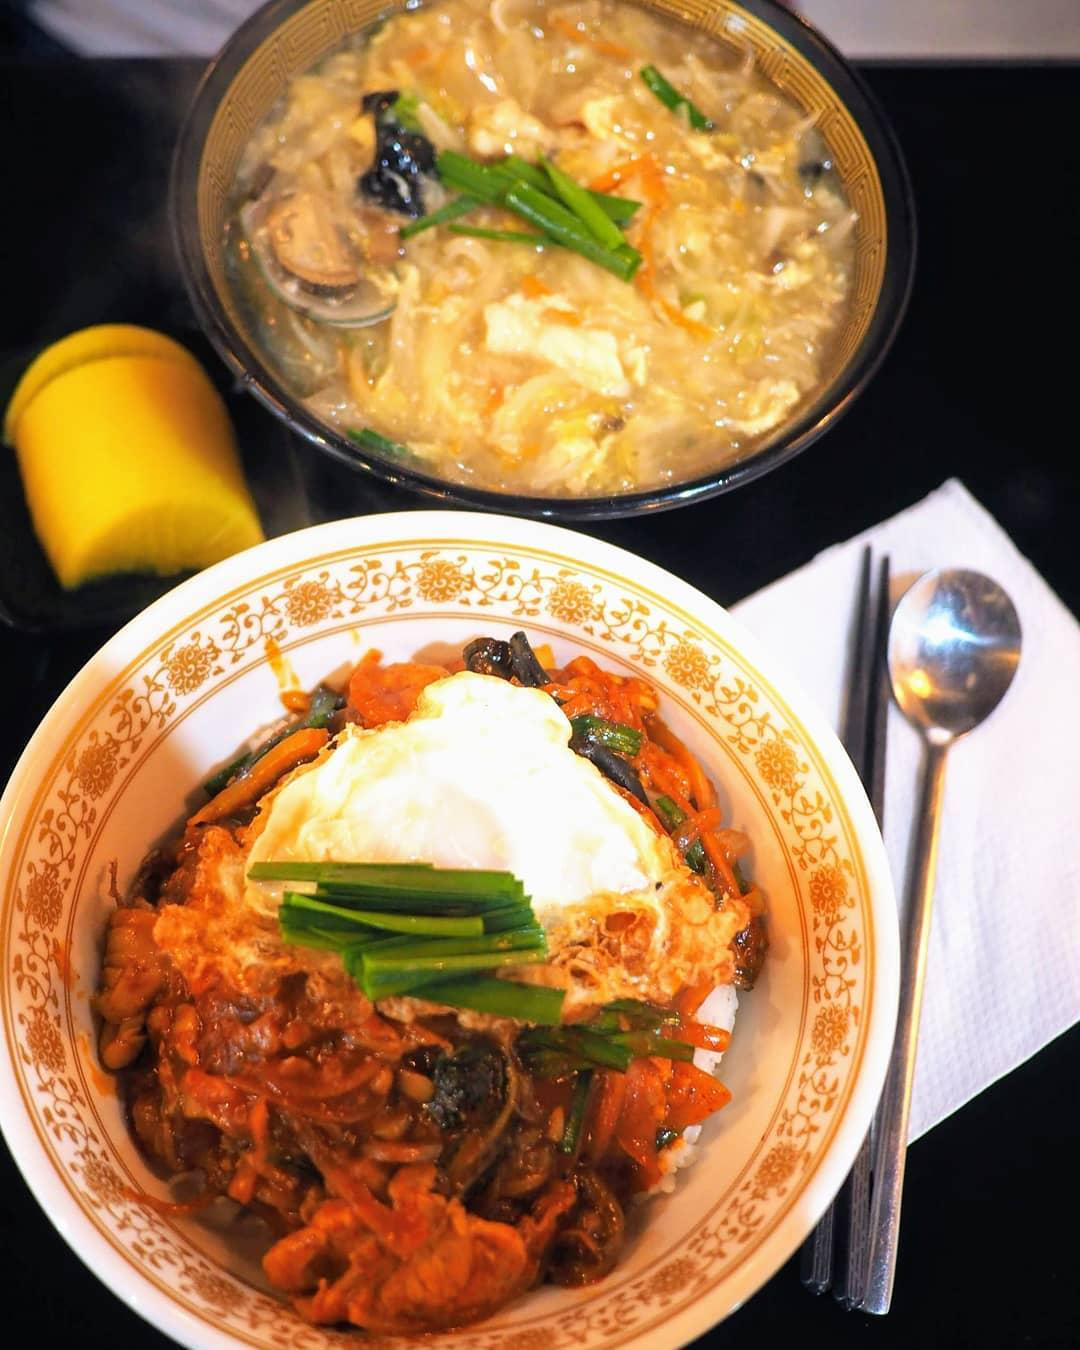

In [115]:
with Image.open(IMAGE_FOLDER + '/' + image_filenames[0]) as img:
    print(type(img))
    print(img.histogram()) # Colour histogram
    display(img)

# 2. "Embedding"
Make a function that takes in a list of filenames and an embedding function and returns "embedding graph"

The format is that the ith row of "embedding_graph" corresponds to the ith filename in image_filenames

In [162]:
def get_embedding_graph(image_filenames = [], embedding_function = lambda img : img.histogram()) -> "[embedding_function(img_0),...]":
    """
    Params:
        - image_filenames: list of filenames within IMAGE_FOLDER.
        - embedding_function: a function which takes in <class 'PIL.JpegImagePlugin.JpegImageFile'>
        and returns a 1D array of floats.

    Returns:
        - embedding_graph: list of embedding where the ith row in embedding_graph.
        corresponds to the ith image_filename in image_filenames.
    """
    embedding_graph = []

    def process_image(image_filename):
        with Image.open(os.path.join(IMAGE_FOLDER, image_filename)) as img:
            return embedding_function(img) # add the embedding of the image to the given function
        
    with ThreadPoolExecutor() as executor:
        embedding_graph = list(tqdm(executor.map(process_image, image_filenames), total=len(image_filenames)))

    return np.array(embedding_graph) # tqdm does not work without the list()

In [167]:
%%time # show how long it took to run
embedding_graph = get_embedding_graph(image_filenames=image_filenames) 
# using ThreadPoolEexecutor speed up from 15s to 3s

100%|██████████| 1000/1000 [00:04<00:00, 228.24it/s]

CPU times: user 24.5 s, sys: 1.76 s, total: 26.2 s
Wall time: 4.55 s


# 3. Get KNN

In [164]:
def get_knn(embedding_graph, n_neighbours=10) -> ("nearest_neighbours_array", "neighbours_distance_array"):
    """
    Params:
        - embedding_graph: numpy array of embeddings. #? not a great description
        - n_neighbours: number of nearest neighbours returned.

    Returns:
        - nearest_neighbour_array: an array where the ith row corresponds to the n
        nearest neighbours for the ith point.
        - neighbours_distance_array: an array where the ith row corresponds to 
        the distances of the n nearest neighbours from the ith point.
    """
    index = pynndescent.NNDescent(embedding_graph, n_neighbors=n_neighbours)
    return index.neighbor_graph # nearest_neighbours_array, neighbours_distance_array 

In [166]:
%%time # show how long it took to run
nearest_neighbours_array, neighbours_distance_array = get_knn(embedding_graph, 10)
nearest_neighbours_array, neighbours_distance_array 

CPU times: user 97.5 ms, sys: 49.7 ms, total: 147 ms
Wall time: 104 ms


(array([[  0, 406, 751, ..., 496, 827, 271],
        [  1, 485, 561, ..., 789, 180, 478],
        [  2, 771, 810, ..., 598, 848, 682],
        ...,
        [997, 959, 183, ..., 586, 214, 247],
        [998, 254, 650, ..., 992, 252, 374],
        [999, 787, 413, ..., 652, 121, 682]], dtype=int32),
 array([[     0.   , 196637.9  , 201569.97 , ..., 218275.25 , 218722.67 ,
         222596.52 ],
        [     0.   ,  10243.636,  22987.988, ...,  25636.074,  26225.057,
          26831.98 ],
        [     0.   ,  57089.812,  59026.62 , ...,  68891.69 ,  69701.75 ,
          69804.99 ],
        ...,
        [     0.   , 272050.72 , 309051.25 , ..., 369602.12 , 370226.9  ,
         374013.2  ],
        [     0.   ,  75680.68 ,  90617.57 , ...,  96045.836,  97750.92 ,
          98052.64 ],
        [     0.   ,  29089.717,  34429.516, ...,  41808.133,  42469.152,
          43012.895]], dtype=float32))

# 3.5 Make some analysis helper functions

In [122]:
def count_neighbour_occurances(nearest_neighbours_array) -> "ranking_array":
    """return array where the ith index is how many times the ith number occured as a neighbour 
    (including as a neighbour of itself)"""
    _, counts = np.unique(nearest_neighbours_array.flatten(), return_counts=True) 
    return counts

In [123]:
count_neighbour_occurances_array = count_neighbour_occurances(nearest_neighbours_array)

In [124]:
def rank_neighbour_occurances(count_neighbour_occurances_array, ascending=True):
    """takes count_neighbour_occurances() output as input and returns a ranked array 
    of indexes in desired order (the index corresponds to a filename in the image_filenames variable)"""
    # first part returns ascending list of sorted indices 
    # second part conditionally flips the order
    return np.argsort(count_neighbour_occurances_array)[::-1+2*ascending] # ascending = True -> 1,  ascending = False -> -1


In [125]:
# you can see that the first value in the left array corresponds to the smallest value in the second array etc.
ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)
ranked_neighbour_occurances, count_neighbour_occurances_array

(array([106, 490, 374, 893,  99,  75, 770, 772, 176, 693, 516, 621,  76,
        241, 273, 843, 984, 939,  88, 483, 552, 687, 424, 505, 830, 145,
        468, 793, 310, 254, 391, 844, 379, 596, 122, 501, 867, 897, 546,
        838, 672, 537, 789, 631, 598, 845, 415, 892, 563, 884, 810, 389,
        998,   2,  20, 650, 192, 251, 550, 849, 271, 570,  39, 308, 535,
        480, 588, 678, 741, 478, 282,  85, 320, 439, 239, 195, 539, 497,
        658, 653, 605, 270, 470, 136, 430,  51, 373,  90, 923, 297, 992,
        148,  36, 518, 991, 883, 675, 344, 682, 114, 181, 188,  79,  35,
        907,  56, 809,   5, 137,  47, 526, 819, 909, 130,  80, 833, 540,
        471,  28, 577, 956,  50, 277,  45, 318, 166, 635, 249, 139, 274,
        146, 256, 218, 465,  58, 402, 238, 107, 744, 750, 466, 933,  93,
        794,   9, 512, 839, 382, 573, 555, 889, 858, 161, 388, 894, 705,
        704, 702, 817, 639, 534, 754, 358, 326, 438, 360, 125, 221, 946,
         32, 109, 765, 375, 610, 879, 973, 491, 966

In [148]:
def get_mean_distance(neighbours_distance_array, exclude_self=True):
    """Takes neighbours_distance_array and returns an array where the ith row
    is the mean distance across the n neighbours from the ith embedded image.

    This mean can conditionally include its distance from itself (0) in the mean calculation"""
    # Set the first value in each row to NaN
    if exclude_self:
        neighbours_distance_array[:, 0] = np.nan
    
    # Compute the mean, ignoring NaN values
    mean_distances = np.nanmean(neighbours_distance_array, axis=1) # AI used for this 
    return mean_distances

In [146]:
neighbours_distance_array[0]

array([      nan, 196637.9 , 201569.97, 206163.55, 216758.06, 216938.44,
       217753.27, 218722.67, 222596.52, 222986.64], dtype=float32)

In [147]:
neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)
neighbours_mean_distance_array

array([ 213347.44 ,   23546.658,   65064.457,  164389.88 ,   89081.64 ,
        119356.22 ,  175029.83 ,   68260.695,   44815.902,   16995.77 ,
         39224.83 ,  199980.45 ,  169447.08 ,  159203.25 ,  127137.46 ,
         72870.734,  189866.28 ,  163564.62 ,  314854.22 ,   65337.75 ,
         77090.81 ,   68353.94 ,   17688.45 ,  155166.19 ,  326998.44 ,
        158989.88 ,   92664.5  ,   35294.312,  113386.99 ,   32561.352,
         35551.215,  124047.   ,  120384.195,  133241.48 ,  371149.44 ,
         19518.963,   73046.29 ,  216503.83 ,  238644.19 ,   97262.12 ,
         22504.305,  118910.234,  156191.31 ,   80620.66 ,  304695.12 ,
         79330.336,   52666.62 ,  115227.34 ,  385273.38 ,  193066.81 ,
         46147.375,  102388.086,  279877.16 ,  187402.06 ,  149164.69 ,
         40110.246,  135486.69 ,  106185.555,  117983.47 ,  188805.52 ,
        128971.555,   92543.72 ,  114953.67 ,  149777.39 ,  147362.9  ,
         88286.61 ,   31283.666,  116148.234,   96142.914,   673

## 3.5.1 Doing some graphing
first lets graph the most common neighbours

import dependencies

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


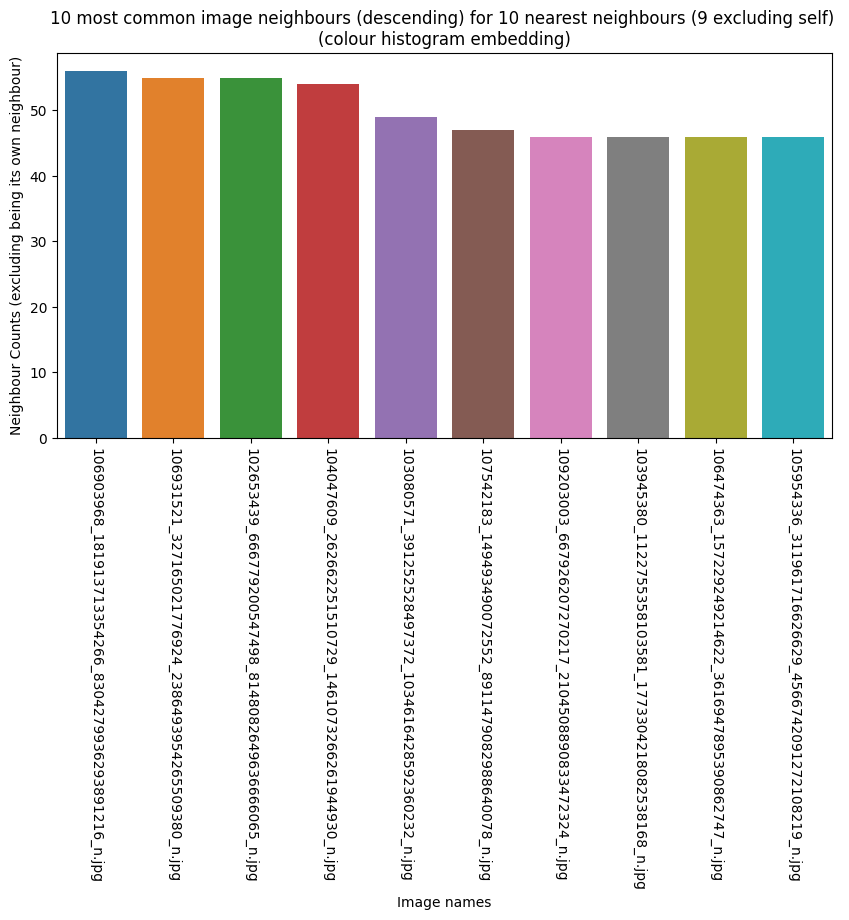

106903968_181913713354266_8304279936293891216_n.jpg


In [133]:
count_neighbour_occurances_array = count_neighbour_occurances(nearest_neighbours_array)
ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[count_neighbour_occurances_array[idx] -1 for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Neighbour Counts (excluding being its own neighbour)")
plt.title(f"{n_most_common} most common image neighbours (descending) for 10 nearest neighbours (9 excluding self) \n(colour histogram embedding)")

plt.show()
print(x[0])

show the top image neighbour

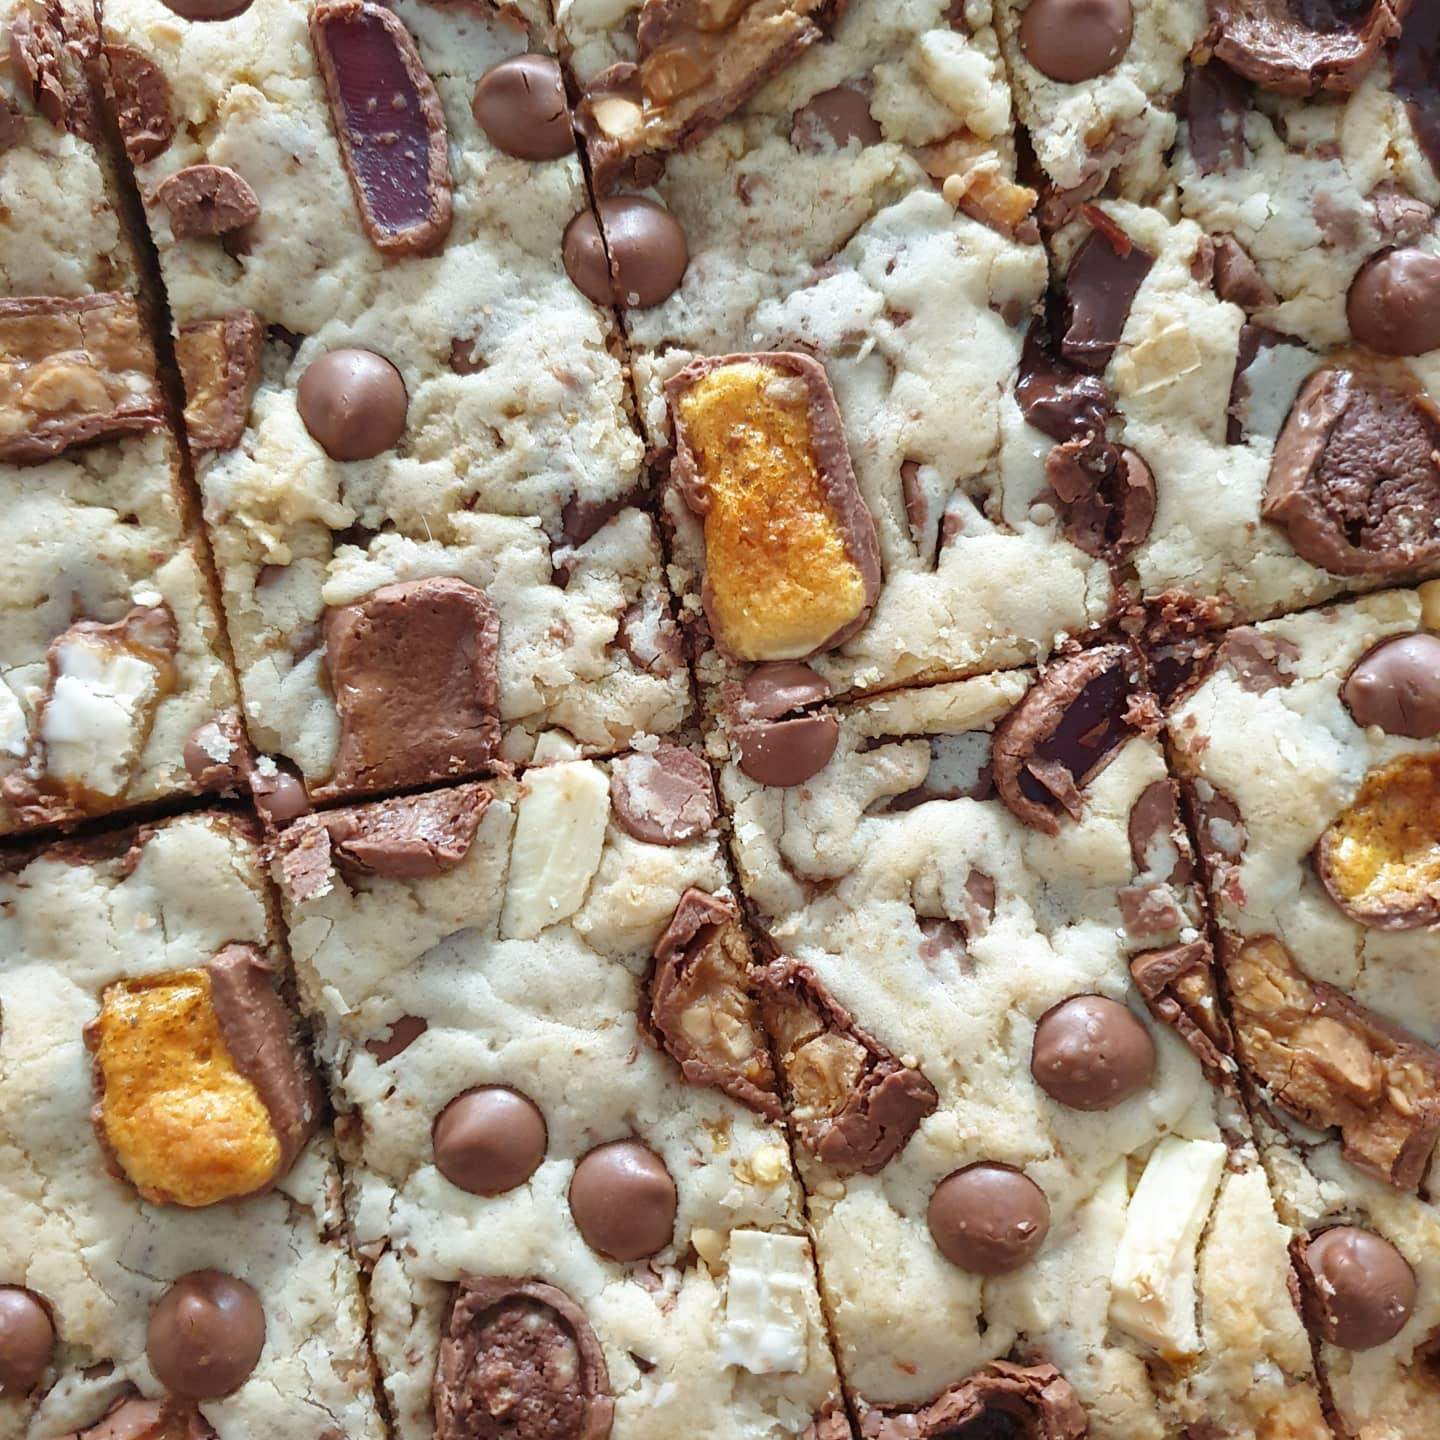

In [134]:
with Image.open(IMAGE_FOLDER + '/' + x[0]) as img:
    display(img)

The next thing to figure out is how to extract the valuable information from the nearest_neighbours_array